# _**Semantic Segmentation on City Roads**_

## Data Wrangling

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import os
if not os.path.exists('dataset1'):
    !wget -q https://www.dropbox.com/s/0pigmmmynbf9xwq/dataset1.zip
    !unzip -q dataset1.zip
    !rm dataset1.zip
    !pip install -q torch_snippets pytorch_model_summary
from torch_snippets import *
from torchvision import transforms
from sklearn.model_selection import train_test_split
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
device

'cuda'

## Data Preprocessing

In [6]:
# Function used to transform image to Tensor and normalize the pixels
tfms = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(
                            [0.485, 0.456, 0.406],
                            [0.229, 0.224, 0.225])
                        ])

In [8]:
class SegData():
    def __init__(self,split:str):
        self.img_path = f"dataset1/images_prepped_{split}"
        self.annot_path = f"dataset1/annotations_prepped_{split}"
        self.items = stems(self.img_path)
        self.split  = split
    
    def __len__(self):
        return len(self.items)

    def __getitem__(self , ix):
        image = read(self.img_path + f"/{self.items[ix]}.png",1)
        image = cv2.resize(image,(224,224))
        mask = read(self.annot_path + f"/{self.items[ix]}.png")
        mask = cv2.resize(mask , (224,224))
        return image , mask 

    def choose(self):
        return self[randint(len(self))]

    def collate_fn(self , batch):
        ims , masks = list(zip(*batch))
        ims = torch.cat([tfms(im.copy()/255.)[None] for im in ims]).float().to(device)
        ce_masks = torch.cat([torch.Tensor(mask)[None] for mask in masks]).long().to(device)
        return ims , ce_masks

In [9]:
trn_ds = SegData("train")
test_ds = SegData("test")
trn_dl = DataLoader(trn_ds , 
                    batch_size=4,
                    shuffle=True,
                    collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(test_ds,
                    batch_size=1,
                    collate_fn=test_ds.collate_fn)

In [101]:
len(trn_ds) , len(test_ds)

(367, 101)

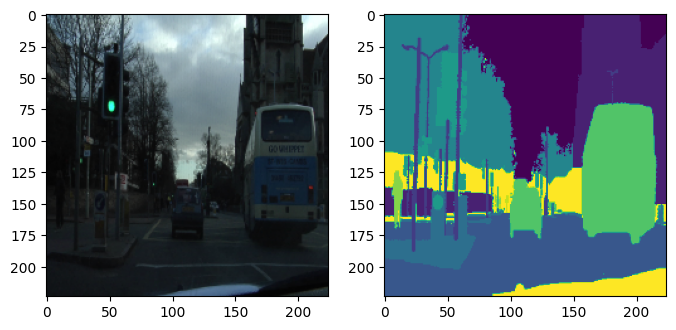

In [10]:
def view(ds:SegData,ix:int):
    img , mask = ds[ix]
    fig = plt.figure(figsize=(8,8))
    fig.add_subplot(1,2,1)
    plt.imshow(img)
    fig.add_subplot(1,2,2)
    plt.imshow(mask)
view(trn_ds,10)

## Model Building

In [11]:
def conv(ic:int , oc:int):
    return nn.Sequential(
        nn.Conv2d(ic,oc,kernel_size=3 , stride=1, padding=1),
        nn.BatchNorm2d(oc),
        nn.ReLU(inplace=True)
    )

In [12]:
def upconv(ic:int , oc:int):
    return nn.Sequential(
        nn.ConvTranspose2d(ic,oc,kernel_size=2,stride=2),
        nn.ReLU(inplace=True)
    )

In [13]:
from torchvision.models import vgg16_bn 
class U_Net(nn.Module):
    def __init__(self,oc:int,pretrained=True):
        super().__init__()
        self.encoder = vgg16_bn(pretrained=pretrained).features
        self.block1 = nn.Sequential(*self.encoder[:6])
        self.block2 = nn.Sequential(*self.encoder[6:13])
        self.block3 = nn.Sequential(*self.encoder[13:20])
        self.block4 = nn.Sequential(*self.encoder[20:27])
        self.block5 = nn.Sequential(*self.encoder[27:34])
        self.bottleneck = nn.Sequential(*self.encoder[34:])

        self.convbottleneck = conv(512,1024)
        self.upconv6 = upconv(1024 , 512)
        self.conv6 = conv(512+512,512)
        self.upconv7 = upconv(512,256)
        self.conv7= conv(512+256,256)
        self.upconv8 = upconv(256,128)
        self.conv8 = conv(128+256,128)
        self.upconv9 = upconv(128,64)
        self.conv9 = conv(128+64,64)
        self.upconv10 = upconv(64,32)
        self.conv10 = conv(32+64,32) 
        self.conv11 = nn.Conv2d(32,oc,kernel_size=1)
    
    def forward(self,x):
        b1 = self.block1(x)
        b2 = self.block2(b1)
        b3 = self.block3(b2)
        b4 = self.block4(b3)
        b5 = self.block5(b4)
        bottleneck = self.bottleneck(b5) 

        x = self.convbottleneck(bottleneck)

        x = self.upconv6(x)
        x = torch.cat([x,b5],dim=1)
        x = self.conv6(x)

        x = self.upconv7(x)
        x = torch.cat([x,b4],dim=1)
        x = self.conv7(x)

        x = self.upconv8(x)
        x = torch.cat([x,b3],dim=1)
        x = self.conv8(x)

        x = self.upconv9(x)
        x = torch.cat([x,b2],dim=1)
        x = self.conv9(x)

        x = self.upconv10(x)
        x = torch.cat([x,b1],dim=1)
        x = self.conv10(x)

        x = self.conv11(x)

        return x

In [15]:
from torchsummary import summary
model = U_Net(21).to(device)
summary(model,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
            Conv2d-2         [-1, 64, 224, 224]           1,792
       BatchNorm2d-3         [-1, 64, 224, 224]             128
       BatchNorm2d-4         [-1, 64, 224, 224]             128
              ReLU-5         [-1, 64, 224, 224]               0
              ReLU-6         [-1, 64, 224, 224]               0
            Conv2d-7         [-1, 64, 224, 224]          36,928
            Conv2d-8         [-1, 64, 224, 224]          36,928
       BatchNorm2d-9         [-1, 64, 224, 224]             128
      BatchNorm2d-10         [-1, 64, 224, 224]             128
             ReLU-11         [-1, 64, 224, 224]               0
             ReLU-12         [-1, 64, 224, 224]               0
        MaxPool2d-13         [-1, 64, 112, 112]               0
        MaxPool2d-14         [-1, 64, 1

In [19]:
ce = nn.CrossEntropyLoss()
def UNetLoss(preds ,targets):
    ce_loss = ce(preds,targets)
    acc = (torch.max(preds,1)[1] == targets).float().mean()
    return ce_loss , acc 

def train_batch(model:U_Net , data , optimizer , criterion = UNetLoss):
    model.train()
    images , masks  = data
    pred = model(images)
    optimizer.zero_grad()
    loss ,acc = criterion(pred , masks)
    loss.backward()
    optimizer.step()
    return loss.item() , acc.item()  

@torch.no_grad()
def val_batch(model , data , optimizer , criterion = UNetLoss):
    model.eval()
    images , masks = data
    pred = model(images)
    loss , acc  = criterion(pred , masks)
    return loss.item() , acc.item()

In [20]:
optimizer = optim.AdamW(model.parameters() , lr=1e-3 )
n_epochs = 20 

In [22]:
log = Report(n_epochs)
for ex in range(n_epochs):
    N = len(trn_dl)
    for (bx , data) in enumerate(trn_dl):
        loss , acc = train_batch(model , data , optimizer)
        log.record(ex+(bx+1)/N,trn_loss = loss , trn_acc = acc , end='\r')
    
    N=len(val_dl)
    for (bx, data) in enumerate(val_dl):
        loss , acc = val_batch(model , data , optimizer)
        log.record(ex+(bx+1)/N,val_loss=loss,val_acc=acc,end='\r')
    
    log.report_avgs(ex+1)

EPOCH: 1.000  val_loss: 0.720  val_acc: 0.842  trn_loss: 0.745  trn_acc: 0.830  (32.54s - 618.30s remaining)
EPOCH: 2.000  val_loss: 0.585  val_acc: 0.864  trn_loss: 0.582  trn_acc: 0.853  (64.40s - 579.58s remaining)
EPOCH: 3.000  val_loss: 0.535  val_acc: 0.865  trn_loss: 0.563  trn_acc: 0.848  (95.96s - 543.77s remaining)
EPOCH: 4.000  val_loss: 0.542  val_acc: 0.859  trn_loss: 0.487  trn_acc: 0.869  (127.61s - 510.42s remaining)
EPOCH: 5.000  val_loss: 0.613  val_acc: 0.831  trn_loss: 0.455  trn_acc: 0.874  (159.53s - 478.58s remaining)
EPOCH: 6.000  val_loss: 0.522  val_acc: 0.840  trn_loss: 0.407  trn_acc: 0.886  (191.18s - 446.08s remaining)
EPOCH: 7.000  val_loss: 0.446  val_acc: 0.867  trn_loss: 0.386  trn_acc: 0.891  (222.91s - 413.97s remaining)
EPOCH: 8.000  val_loss: 0.434  val_acc: 0.869  trn_loss: 0.369  trn_acc: 0.895  (254.61s - 381.91s remaining)
EPOCH: 9.000  val_loss: 0.415  val_acc: 0.878  trn_loss: 0.357  trn_acc: 0.899  (286.36s - 350.00s remaining)
EPOCH: 10.000

100%|██████████| 121/121 [00:00<00:00, 1163.08it/s]


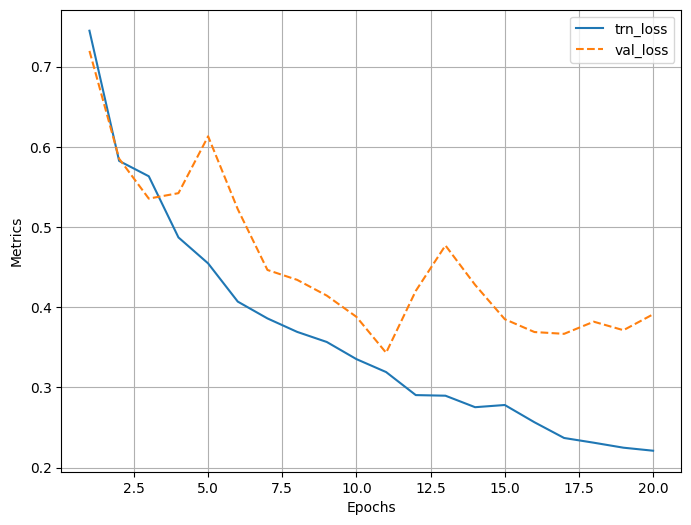

In [27]:
log.plot_epochs(['trn_loss','val_loss'])

In [75]:
from dice import *
def rand_check(ix):
    im, mask = test_ds.collate_fn([test_ds[ix]])
    _mask = model(im)
    _, _mask = torch.max(_mask, dim=1)
    dcf = multiclass_dice_coeff(mask , _mask)
    print(f"Dice Coeffcient = {dcf}")
    subplots([im[0].permute(1,2,0).detach().cpu()[:,:,0], mask.permute(1,2,0).detach().cpu()[:,:,0]
    ,_mask.permute(1,2,0).detach().cpu()[:,:,0]], titles=['Original image','Original mask','Predicted mask'],figsize=(12,8))

Dice Coeffcient = 4.430752754211426

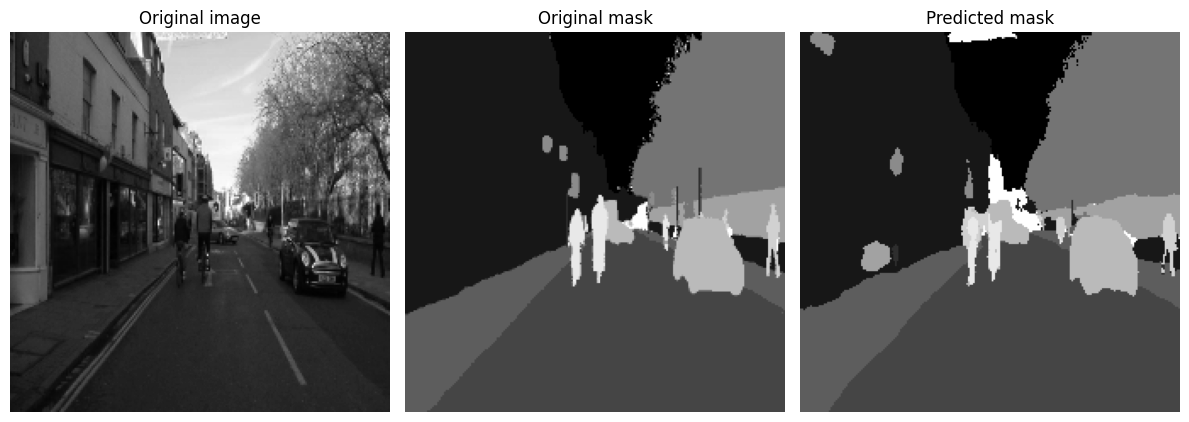

In [76]:
rand_check(0)

Dice Coeffcient = 4.5522780418396

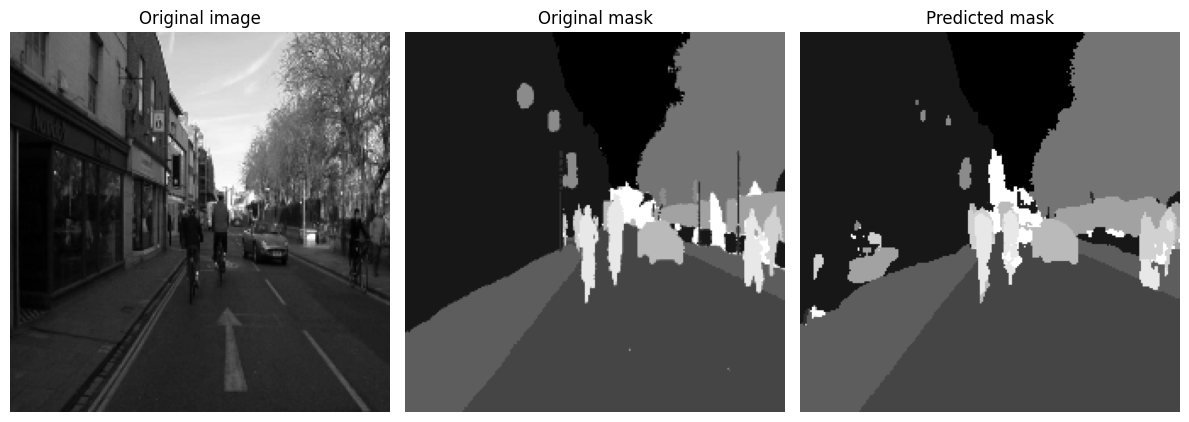

In [77]:
rand_check(25)

Dice Coeffcient = 4.520056247711182

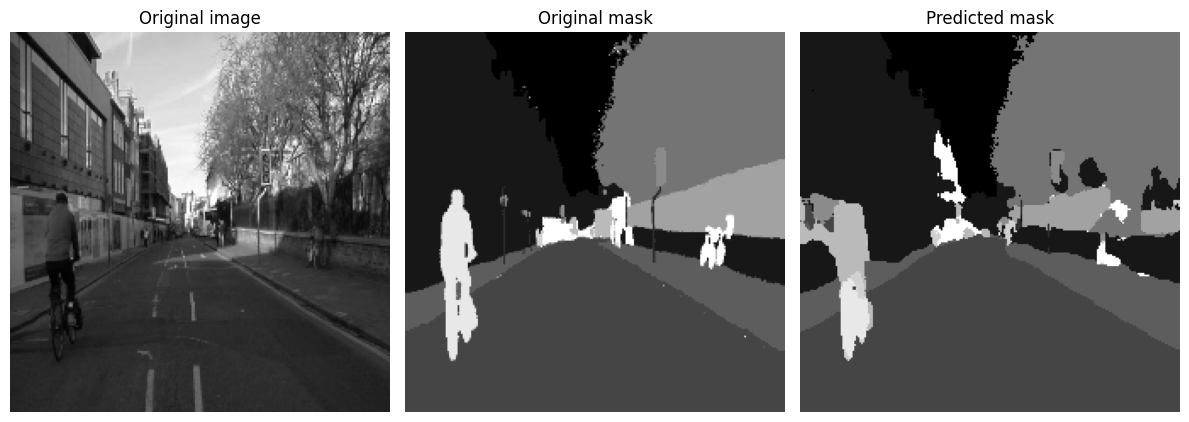

In [100]:
rand_check(100)

In [98]:
from torch import Tensor
def dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all batches, or for a single mask
    assert input.size() == target.size()
    assert input.dim() == 3 or not reduce_batch_first

    sum_dim = (-1, -2) if input.dim() == 2 or not reduce_batch_first else (-1, -2, -3)

    inter = 2 * (input * target).sum(dim=sum_dim)
    sets_sum = input.sum(dim=sum_dim) + target.sum(dim=sum_dim)
    sets_sum = torch.where(sets_sum == 0, inter, sets_sum)

    dice = (inter + epsilon) / (sets_sum + epsilon)
    return dice.mean()


def multiclass_dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all classes
    return dice_coeff(input.flatten(0, 1), target.flatten(0, 1), reduce_batch_first, epsilon)

def check_accuracy(loader, model, device="cuda"):
    num_correct = 0
    num_pixels  = 0
    dice_score  = 0
    model.eval()

    with torch.no_grad():
        for ix ,data in enumerate(loader):
            img , mask = data 
            _,preds = torch.max(model(img),dim=1)
            #print(preds.shape)
            dice_score = multiclass_dice_coeff(mask ,preds)

    print(f"Dice score: {dice_score/len(loader)*100:.2f}")
    model.train()

In [99]:
check_accuracy(val_dl , model)

Dice score: 4.60

---